In [14]:
! pip install lughaatNLP

    extract-msg (<=0.29.*)
                 ~~~~~~~^

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# LIBRARIES AND DEPENDENCIES

In [15]:
from LughaatNLP import NER_Urdu, POS_urdu, LughaatNLP
import pandas as pd
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk import ngrams
from collections import Counter
from gensim.models import Word2Vec
from joblib import Parallel, delayed
import multiprocessing

urdu_text_processing = LughaatNLP()



# Spelling Checker

In [16]:
tqdm.pandas()

# Load the dataset
df = pd.read_csv('urdu_sarcastic_dataset.csv')

# Ensure the 'urdu_text' column is string type and handle missing values
df['urdu_text'] = df['urdu_text'].fillna('').astype(str)

# Function to apply spell checker to individual sentences
def process_sentence(sentence):
    return urdu_text_processing.corrected_sentence_spelling(sentence, 60)

# Define the number of CPUs available for multiprocessing
num_cores = multiprocessing.cpu_count()

# Apply the spell checker function using multiprocessing and display the progress bar
df['corrected_text'] = Parallel(n_jobs=num_cores)(delayed(process_sentence)(sentence) for sentence in tqdm(df['urdu_text']))

# View the output
print(df[['urdu_text', 'corrected_text']].head())

100%|██████████| 20060/20060 [14:47<00:00, 22.61it/s]


                                           urdu_text  \
0  🤣😂😂 ہو لینے دے میری شادی فسادن ٹھیک ہے کوجی نہ...   
1  چل مہمانوں میں کھانا سرو کر چڑیل چاچی نوں دسدی...   
2  کامران خان آپکی دن بھریہ زمہ داری لگائی گئی اپ...   
3                                       نہیں پائین 😎   
4   `` مراد علی شاہ کے بھیس میں ڈی جی آئی ایس آئی...   

                                      corrected_text  
0  🤣😂😂 ہو لینے دے میری شادی فساد ٹھیک ہے کوجی نہی...  
1  چل مہمانوں میں کھانا سروس کر چڑیل چاچا دنوں دس...  
2  کامران خان آپکی دن بحریہ زمہ داری لگائی گئی اپ...  
3                                      نہیں پائینل 😎  
4  `` مراد علی شاہ کے بھیس میں ڈی جی آئی ایس آئی ...  


# Stop Words Removing

In [17]:
# Apply stopword removal on the spell-checked text
df['filtered_text'] = df['corrected_text'].apply(urdu_text_processing.remove_stopwords)

# View the output
print(df[['urdu_text', 'filtered_text']].head())


                                           urdu_text  \
0  🤣😂😂 ہو لینے دے میری شادی فسادن ٹھیک ہے کوجی نہ...   
1  چل مہمانوں میں کھانا سرو کر چڑیل چاچی نوں دسدی...   
2  کامران خان آپکی دن بھریہ زمہ داری لگائی گئی اپ...   
3                                       نہیں پائین 😎   
4   `` مراد علی شاہ کے بھیس میں ڈی جی آئی ایس آئی...   

                                       filtered_text  
0                  🤣😂😂 لینے شادی فساد ٹھیک کوجی 😐😐😐🤣  
1  چل مہمانوں کھانا سروس چڑیل چاچا دنوں دستی آؤں ...  
2  کامران خان دن بحریہ زمہ داری لگائی گئی اپوزیشن...  
3                                           پائینل 😎  
4            `` مراد علی شاہ بھیس ڈی آئی آئی '' حامی  


# Punctuation, Emojis, and Hashtags

In [18]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove emojis
    text = re.sub(r'[^\w\s,۔!?]', '', text)  # Keeps words, punctuation, and Urdu characters
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)  # Remove hashtags
    # Remove unnecessary punctuation
    text = re.sub(r'[^\w\s]', '', text)  # Remove all punctuation except for whitespace
    return text

# Clean the filtered text entries
df['cleaned_text'] = df['filtered_text'].apply(clean_text)

# Print the first 5 rows to check the results
print(df[['urdu_text', 'filtered_text', 'cleaned_text']].head())

                                           urdu_text  \
0  🤣😂😂 ہو لینے دے میری شادی فسادن ٹھیک ہے کوجی نہ...   
1  چل مہمانوں میں کھانا سرو کر چڑیل چاچی نوں دسدی...   
2  کامران خان آپکی دن بھریہ زمہ داری لگائی گئی اپ...   
3                                       نہیں پائین 😎   
4   `` مراد علی شاہ کے بھیس میں ڈی جی آئی ایس آئی...   

                                       filtered_text  \
0                  🤣😂😂 لینے شادی فساد ٹھیک کوجی 😐😐😐🤣   
1  چل مہمانوں کھانا سروس چڑیل چاچا دنوں دستی آؤں ...   
2  کامران خان دن بحریہ زمہ داری لگائی گئی اپوزیشن...   
3                                           پائینل 😎   
4            `` مراد علی شاہ بھیس ڈی آئی آئی '' حامی   

                                        cleaned_text  
0                          لینے شادی فساد ٹھیک کوجی   
1  چل مہمانوں کھانا سروس چڑیل چاچا دنوں دستی آؤں میں  
2  کامران خان دن بحریہ زمہ داری لگائی گئی اپوزیشن...  
3                                            پائینل   
4                 مراد علی شاہ بھیس ڈی آئی آئی  حام

# Short Conversations

In [19]:
def filter_short_posts(text):
    # Split the text into words
    word_count = len(text.split())
    # Return True if the post has 3 or more words
    return word_count >= 3

# Apply the filtering function to the cleaned text
df['is_long_enough'] = df['cleaned_text'].apply(filter_short_posts)

# Optionally, filter the DataFrame to include only longer posts
df_filtered = df[df['is_long_enough']]

# Print the first 5 rows of the filtered DataFrame
print(df_filtered[['urdu_text', 'cleaned_text']].head())

                                           urdu_text  \
0  🤣😂😂 ہو لینے دے میری شادی فسادن ٹھیک ہے کوجی نہ...   
1  چل مہمانوں میں کھانا سرو کر چڑیل چاچی نوں دسدی...   
2  کامران خان آپکی دن بھریہ زمہ داری لگائی گئی اپ...   
4   `` مراد علی شاہ کے بھیس میں ڈی جی آئی ایس آئی...   
5        قابل اعتبار ہی اکثر قاتل اعتبار ہوتے ہیں 💔🔥   

                                        cleaned_text  
0                          لینے شادی فساد ٹھیک کوجی   
1  چل مہمانوں کھانا سروس چڑیل چاچا دنوں دستی آؤں میں  
2  کامران خان دن بحریہ زمہ داری لگائی گئی اپوزیشن...  
4                 مراد علی شاہ بھیس ڈی آئی آئی  حامی  
5                           قابل اعتبار قاتل اعتبار   


# Normalization

In [20]:
df['normalized_text'] = df['cleaned_text'].apply(urdu_text_processing.normalize)

# Print the first 5 rows to check the results
print(df[['urdu_text', 'filtered_text', 'cleaned_text', 'normalized_text']].head())

                                           urdu_text  \
0  🤣😂😂 ہو لینے دے میری شادی فسادن ٹھیک ہے کوجی نہ...   
1  چل مہمانوں میں کھانا سرو کر چڑیل چاچی نوں دسدی...   
2  کامران خان آپکی دن بھریہ زمہ داری لگائی گئی اپ...   
3                                       نہیں پائین 😎   
4   `` مراد علی شاہ کے بھیس میں ڈی جی آئی ایس آئی...   

                                       filtered_text  \
0                  🤣😂😂 لینے شادی فساد ٹھیک کوجی 😐😐😐🤣   
1  چل مہمانوں کھانا سروس چڑیل چاچا دنوں دستی آؤں ...   
2  کامران خان دن بحریہ زمہ داری لگائی گئی اپوزیشن...   
3                                           پائینل 😎   
4            `` مراد علی شاہ بھیس ڈی آئی آئی '' حامی   

                                        cleaned_text  \
0                          لینے شادی فساد ٹھیک کوجی    
1  چل مہمانوں کھانا سروس چڑیل چاچا دنوں دستی آؤں میں   
2  کامران خان دن بحریہ زمہ داری لگائی گئی اپوزیشن...   
3                                            پائینل    
4                 مراد علی شاہ بھیس ڈی آئی آئی

# Stemming

In [21]:
df['stemmed_text'] = df['normalized_text'].apply(urdu_text_processing.urdu_stemmer)

# Print the first 5 rows to check the results
print(df[['urdu_text', 'filtered_text', 'normalized_text', 'stemmed_text']].head())

                                           urdu_text  \
0  🤣😂😂 ہو لینے دے میری شادی فسادن ٹھیک ہے کوجی نہ...   
1  چل مہمانوں میں کھانا سرو کر چڑیل چاچی نوں دسدی...   
2  کامران خان آپکی دن بھریہ زمہ داری لگائی گئی اپ...   
3                                       نہیں پائین 😎   
4   `` مراد علی شاہ کے بھیس میں ڈی جی آئی ایس آئی...   

                                       filtered_text  \
0                  🤣😂😂 لینے شادی فساد ٹھیک کوجی 😐😐😐🤣   
1  چل مہمانوں کھانا سروس چڑیل چاچا دنوں دستی آؤں ...   
2  کامران خان دن بحریہ زمہ داری لگائی گئی اپوزیشن...   
3                                           پائینل 😎   
4            `` مراد علی شاہ بھیس ڈی آئی آئی '' حامی   

                                     normalized_text  \
0                           لینے شادی فساد ٹھیک کوجی   
1  چل مہمانوں کھانا سروس چڑیل چاچا دنوں دستی اؤں میں   
2  کامران خان دن بحریہ زمہ داری لگائی گئی اپوزیشن...   
3                                             پائینل   
4                  مراد علی شاہ بھیس ڈی ائی ائ

# Lemmatization

In [22]:
df['lemmatize_text'] = df['normalized_text'].apply(urdu_text_processing.lemmatize_sentence)

# Print the first 5 rows to check the results
print(df[['urdu_text', 'filtered_text', 'normalized_text', 'lemmatize_text']].head())

                                           urdu_text  \
0  🤣😂😂 ہو لینے دے میری شادی فسادن ٹھیک ہے کوجی نہ...   
1  چل مہمانوں میں کھانا سرو کر چڑیل چاچی نوں دسدی...   
2  کامران خان آپکی دن بھریہ زمہ داری لگائی گئی اپ...   
3                                       نہیں پائین 😎   
4   `` مراد علی شاہ کے بھیس میں ڈی جی آئی ایس آئی...   

                                       filtered_text  \
0                  🤣😂😂 لینے شادی فساد ٹھیک کوجی 😐😐😐🤣   
1  چل مہمانوں کھانا سروس چڑیل چاچا دنوں دستی آؤں ...   
2  کامران خان دن بحریہ زمہ داری لگائی گئی اپوزیشن...   
3                                           پائینل 😎   
4            `` مراد علی شاہ بھیس ڈی آئی آئی '' حامی   

                                     normalized_text  \
0                           لینے شادی فساد ٹھیک کوجی   
1  چل مہمانوں کھانا سروس چڑیل چاچا دنوں دستی اؤں میں   
2  کامران خان دن بحریہ زمہ داری لگائی گئی اپوزیشن...   
3                                             پائینل   
4                  مراد علی شاہ بھیس ڈی ائی ائ

# Tokenization

In [23]:
df['tokenized_text'] = df['lemmatize_text'].apply(urdu_text_processing.urdu_tokenize)

In [24]:
print(df[['tokenized_text']].head())

                                      tokenized_text
0                     [لینا, شادی, فساد, ٹھیک, کوجی]
1  [چلنا, مہمان, کھا, سروس, چڑیل, چاچا, دن, دستی,...
2  [کامران, خان, دن, بحریہ, زمہ, داری, لگنا, جانا...
3                                           [پائینل]
4         [مراد, علی, شاہ, بھیس, ڈی, ائی, ائی, حامی]


# Saving in csv file

In [25]:
lemmatized_df = df[['lemmatize_text', 'is_sarcastic']]

# Save the DataFrame to a new CSV file
lemmatized_df.to_csv('lemmatized_urdu_sarcastic_dataset.csv', index=False, encoding='utf-8-sig')

# Print the first few rows to verify
print(lemmatized_df.head())

                                      lemmatize_text  is_sarcastic
0                           لینا شادی فساد ٹھیک کوجی           1.0
1      چلنا مہمان کھا سروس چڑیل چاچا دن دستی اؤں میں           1.0
2  کامران خان دن بحریہ زمہ داری لگنا جانا اپوزیشن...           0.0
3                                             پائینل           0.0
4                  مراد علی شاہ بھیس ڈی ائی ائی حامی           1.0


# Distribution

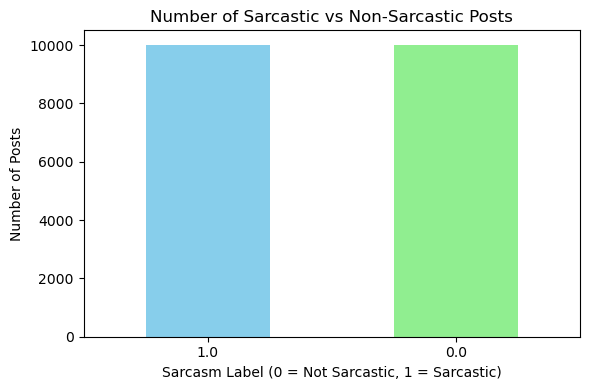

In [26]:


# Load the lemmatized dataset
df = pd.read_csv('lemmatized_urdu_sarcastic_dataset.csv')

# Count the number of sarcastic and non-sarcastic entries
sarcastic_counts = df['is_sarcastic'].value_counts()

# Plot the counts
plt.figure(figsize=(6, 4))
sarcastic_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])

# Add labels and title
plt.title('Number of Sarcastic vs Non-Sarcastic Posts')
plt.xlabel('Sarcasm Label (0 = Not Sarcastic, 1 = Sarcastic)')
plt.ylabel('Number of Posts')

# Show plot
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.tight_layout()
plt.show()


# Tf-IDF

In [27]:


# Load the lemmatized dataset
df = pd.read_csv('lemmatized_urdu_sarcastic_dataset.csv')

# Combine all the text data into a single column if needed (ensure 'lemmatize_text' column is present)
corpus = df['lemmatize_text'].fillna('')

# Initialize the Tf-IDF vectorizer for Urdu text
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features for more words

# Fit the model and transform the text into a Tf-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Get the feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the sum of TF-IDF scores for each word across all documents
tfidf_scores = tfidf_matrix.sum(axis=0).A1

# Create a DataFrame with words and their corresponding TF-IDF scores
tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_scores})

# Sort the DataFrame by the highest TF-IDF scores
tfidf_df = tfidf_df.sort_values(by='tfidf_score', ascending=False)

# Display the top 10 words with the highest TF-IDF scores
top_10_words = tfidf_df.head(10)
print(top_10_words)

# Optional: Save the results to a CSV file
top_10_words.to_csv('top_10_tfidf_words.csv', index=False)


        word  tfidf_score
72      اللہ   354.014600
137      بات   352.194118
904     کوئی   350.253881
926     کہنا   330.514771
305      خان   279.868725
965       ھے   278.265683
980     ہونا   268.198688
251     جانا   262.438253
765  پاکستان   244.883849
597     لگنا   242.175717


# Word2vec

In [28]:


# Load dataset
df = pd.read_csv('lemmatized_urdu_sarcastic_dataset.csv')

# Ensure all entries in 'lemmatize_text' column are strings and handle NaN values
df['lemmatize_text'] = df['lemmatize_text'].fillna('').astype(str)

# Enable tqdm for pandas
tqdm.pandas()

# Apply tokenization with progress bar
df['tokenized_text'] = df['lemmatize_text'].progress_apply(urdu_text_processing.urdu_tokenize)

# Print the first 5 rows to check the results
print(df[['tokenized_text']].head())


100%|██████████| 20060/20060 [00:00<00:00, 104194.70it/s]

                                      tokenized_text
0                     [لینا, شادی, فساد, ٹھیک, کوجی]
1  [چلنا, مہمان, کھا, سروس, چڑیل, چاچا, دن, دستی,...
2  [کامران, خان, دن, بحریہ, زمہ, داری, لگنا, جانا...
3                                           [پائینل]
4         [مراد, علی, شاہ, بھیس, ڈی, ائی, ائی, حامی]


In [29]:


# Assuming df is the lemmatized dataset with tokenized text in 'tokenized_text' column
# Each row in 'tokenized_text' is a list of tokenized words (sentences)

# Train Word2Vec model on tokenized text
model = Word2Vec(sentences=df['tokenized_text'], vector_size=100, window=5, min_count=2, sg=1, workers=4)

# Query the model for the top 5 words most similar to "اچھا" (good)
similar_words = model.wv.most_similar("اچھا", topn=5)

# Display the similar words and their similarity scores
print("Top 5 words most similar to 'اچھا':")
for word, similarity in similar_words:
    print(f"{word}: {similarity:.4f}")


Top 5 words most similar to 'اچھا':
حال: 0.8309
کافی: 0.8299
قسمت: 0.8133
پسند: 0.8117
سپلائی: 0.8046


In [30]:

# Assuming df is the lemmatized dataset with tokenized text in 'tokenized_text' column
# Each row in 'tokenized_text' is a list of tokenized words (sentences)

# Train Word2Vec model on tokenized text
model = Word2Vec(sentences=df['tokenized_text'], vector_size=100, window=5, min_count=2, sg=1, workers=4)

# Get word embeddings
word_vectors = model.wv
words = word_vectors.index_to_key  # List of words in the model's vocabulary
embeddings = [word_vectors[word] for word in words]  # Corresponding embeddings

# Create a DataFrame to store words and their embeddings
embedding_df = pd.DataFrame(embeddings, index=words)

# Save embeddings to CSV
embedding_df.to_csv('word_embeddings.csv', index_label='word')

# Display success message
print("Word embeddings saved to 'word_embeddings.csv'.")


Word embeddings saved to 'word_embeddings.csv'.


# Unigram, Bigram, and Trigram Analysis

In [31]:

# Load dataset
df = pd.read_csv('lemmatized_urdu_sarcastic_dataset.csv')

# Ensure 'lemmatize_text' column is in string format and handle NaN values
df['lemmatize_text'] = df['lemmatize_text'].fillna('').astype(str)

# Tokenize the lemmatized text into words
nltk.download('punkt')  # Download the punkt tokenizer if not already done
df['tokenized_text'] = df['lemmatize_text'].apply(nltk.word_tokenize)

# Create a list of all words from the tokenized text
all_words = [word for tokens in df['tokenized_text'] for word in tokens]

# Create unigrams, bigrams, and trigrams
unigrams = Counter(all_words)
bigrams = Counter(ngrams(all_words, 2))
trigrams = Counter(ngrams(all_words, 3))

# Get the most common unigrams, bigrams, and trigrams
top_10_unigrams = unigrams.most_common(10)
top_10_bigrams = bigrams.most_common(10)
top_10_trigrams = trigrams.most_common(10)

# Print the results
print("Top 10 Unigrams:")
for word, freq in top_10_unigrams:
    print(f"{word}: {freq}")

print("\nTop 10 Bigrams:")
for bigram, freq in top_10_bigrams:
    print(f"{' '.join(bigram)}: {freq}")

print("\nTop 10 Trigrams:")
for trigram, freq in top_10_trigrams:
    print(f"{' '.join(trigram)}: {freq}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Natha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Top 10 Unigrams:
_: 3459
کہنا: 1396
کوئی: 1373
اللہ: 1263
بات: 1239
خان: 1176
ھے: 1147
پاکستان: 1057
جانا: 965
ہونا: 911

Top 10 Bigrams:
_ _: 1131
عمران خان: 510
نواز شریف: 466
سندھ پولیس: 305
ارمی چیف: 227
جزا اللہ: 208
کیپٹن صفدر: 184
مریم نواز: 159
ن لیگ: 155
اللہ علیہ: 143

Top 10 Trigrams:
_ _ _: 506
پینا ٹی ائی: 117
صلی اللہ علیہ: 100
پینا ڈی ایم: 88
پٹواریوں _ _: 80
جزا اللہ خیر: 80
_ _ سفر: 77
_ _ مادرملت: 77
فالو فالو بیک: 73
بزدارکی _ پرواز: 67


# Model Training and Evaluation

In [32]:

# Load your embeddings and labels
embeddings_df = pd.read_csv('word_embeddings.csv')
labels_df = pd.read_csv('lemmatized_urdu_sarcastic_dataset.csv')

# Check the column names in labels_df
print("Labels DataFrame Columns:", labels_df.columns)

# Create a dictionary of word embeddings
embeddings_dict = dict(zip(
    embeddings_df['word'],
    embeddings_df.iloc[:, 1:].values.tolist()  # This grabs all columns from 1 onward
))

# Function to create sentence embeddings by averaging word embeddings
def create_sentence_embedding(tokens):
    embeddings = []
    for token in tokens:
        if token in embeddings_dict:
            embeddings.append(embeddings_dict[token])
    if embeddings:  # Avoid division by zero
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(len(next(iter(embeddings_dict.values()))))  # Return a zero vector

# Create sentence embeddings for each Urdu text
def safe_create_embedding(text):
    if isinstance(text, str):  # Check if the text is a string
        return create_sentence_embedding(text.split())
    else:
        return np.zeros(len(next(iter(embeddings_dict.values()))))  # Return a zero vector for non-string entries

labels_df['sentence_embedding'] = labels_df['lemmatize_text'].apply(safe_create_embedding)

# Convert list of embeddings to a DataFrame
embeddings_matrix = np.vstack(labels_df['sentence_embedding'].values)

# Prepare labels for classification
X = embeddings_matrix
y = labels_df['is_sarcastic'].values  # Assuming 'is_sarcastic' is your label column

# Encode labels if they are not numerical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Choose a model: Logistic Regression, SVM, or Naive Bayes
model_choice = 'Logistic Regression'  # Change this to 'SVM' or 'Naive Bayes' as needed

if model_choice == 'Logistic Regression':
    model = LogisticRegression(max_iter=1000)
elif model_choice == 'SVM':
    model = SVC()
elif model_choice == 'Naive Bayes':
    model = MultinomialNB()
else:
    raise ValueError("Invalid model choice. Choose 'Logistic Regression', 'SVM', or 'Naive Bayes'.")

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_.astype(str)))

Labels DataFrame Columns: Index(['lemmatize_text', 'is_sarcastic'], dtype='object')
Accuracy: 0.7345463609172482
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.74      2060
         1.0       0.72      0.75      0.73      1942
         nan       0.00      0.00      0.00        10

    accuracy                           0.73      4012
   macro avg       0.49      0.49      0.49      4012
weighted avg       0.73      0.73      0.73      4012



C:\Users\Natha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Natha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Natha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Testin on Sample Test Sentences

In [33]:
# Define sample Urdu sentences for prediction
sample_sentences = [
    "کتنے اچھے ہیں یہ لوگ جو ہر وقت میرا مذاق اڑاتے ہیں۔",  # Expected: Sarcastic
    "آج موسم بہت خوشگوار ہے۔",  # Expected: Non-Sarcastic
    "یہ کھانا بہت مزیدار ہے۔",  # Expected: Non-Sarcastic
    "واقعی بہت مزہ آیا، تم نے مزے کا بیڑا غرق کر دیا۔",  # Expected: Sarcastic
    "کیا زبردست فیصلہ تھا، سب کچھ برباد ہو گیا۔"  # Expected: Sarcastic
]

# Function to predict sarcasm (0 for non-sarcastic, 1 for sarcastic)
def predict_sarcasm(sentences):
    predictions = []
    for sentence in sentences:
        # Create sentence embedding
        sentence_embedding = create_sentence_embedding(sentence.split())
        
        # Reshape to match input format for model
        sentence_embedding_reshaped = np.array(sentence_embedding).reshape(1, -1)
        
        # Make prediction
        pred = model.predict(sentence_embedding_reshaped)
        
        # Append prediction (0 or 1)
        predictions.append(pred[0])
        
    return predictions

# Predict sarcasm for the sample sentences
predictions = predict_sarcasm(sample_sentences)

# Display the results
for sentence, prediction in zip(sample_sentences, predictions):
    sarcasm_label = "Sarcastic" if prediction == 1 else "Non-Sarcastic"
    print(f"Sentence: {sentence}\nPrediction: {sarcasm_label}\n")


Sentence: کتنے اچھے ہیں یہ لوگ جو ہر وقت میرا مذاق اڑاتے ہیں۔
Prediction: Sarcastic

Sentence: آج موسم بہت خوشگوار ہے۔
Prediction: Non-Sarcastic

Sentence: یہ کھانا بہت مزیدار ہے۔
Prediction: Non-Sarcastic

Sentence: واقعی بہت مزہ آیا، تم نے مزے کا بیڑا غرق کر دیا۔
Prediction: Sarcastic

Sentence: کیا زبردست فیصلہ تھا، سب کچھ برباد ہو گیا۔
Prediction: Sarcastic

